In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

titanic = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

print(titanic.head())
print(titanic_test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [4]:
print(titanic['Survived'].value_counts())

0    549
1    342
Name: Survived, dtype: int64


In [5]:
survivors = titanic[titanic['Survived'] == 1]
deceased = titanic[titanic['Survived'] == 0]

print('\nTotal:\n',titanic.describe())
print('Survivors:\n',survivors.describe())
print('\nDeceased:\n',deceased.describe())


Total:
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
Survivors:
        PassengerId  Survived      Pclass         Age       S

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001921E336E48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001921E7474A8>]], dtype=object)

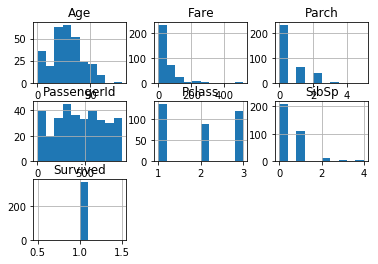

In [6]:
survivors.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001921E6FD6A0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001921EDE6240>]], dtype=object)

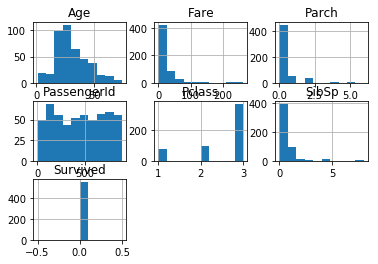

In [7]:
deceased.hist()

In [8]:
titanic["Age"] = titanic['Age'].fillna(titanic['Age'].median())

titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1

In [9]:
print(titanic['Embarked'].value_counts())
titanic["Embarked"] = titanic["Embarked"].fillna("S")

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 2
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 3

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

lr = LinearRegression()
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (titanic[predictors].iloc[train,:])
    train_target = titanic["Survived"].iloc[train]
    lr.fit(train_predictors, train_target)
    test_predictions = lr.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)


In [24]:
predictions = np.concatenate(predictions, axis=0)

predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

accuracy = len(titanic[titanic['Survived'] == predictions])/len(titanic)
print(accuracy)

0.7833894500561167


In [26]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.794612794613


In [27]:
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

In [30]:
alg = LogisticRegression(random_state=1)

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle.csv", index=False)

In [44]:
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=5, min_samples_leaf=2)

kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

print(np.mean(scores))

0.824915824916


In [45]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [48]:
import re

# A function to get the title from a name
def get_title(name):
    # Use a regular expression to search for a title  
    # Titles always consist of capital and lowercase letters, and end with a period
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""

# Get all of the titles, and print how often each one occurs
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer  
# Some titles are very rare, so they're compressed into the same codes as other titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything
print(pd.value_counts(titles))

# Add in the title column
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Ms            1
Sir           1
Mme           1
Capt          1
Don           1
Countess      1
Jonkheer      1
Lady          1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [50]:
import operator

# A dictionary mapping family name to ID
family_id_mapping = {}

# A function to get the ID for a particular row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family ID
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the ID in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum ID from the mapping, and add 1 to it if we don't have an ID
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family IDs with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family IDs, so we'll compress all of the families with less than three members into one code
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique ID
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


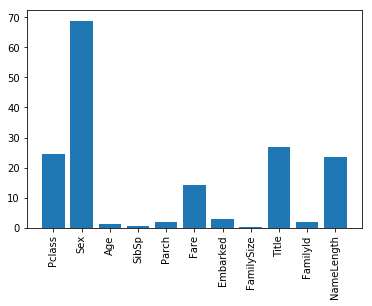

0.817059483726


In [51]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId", "NameLength"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform them from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores  
# Do you see how "Pclass", "Sex", "Title", and "Fare" are the best features?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)
# Compute the accuracy score for all the cross-validation folds; this is much simpler than what we did before
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# The algorithms we want to ensemble
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=50, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]],
    [RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=5, min_samples_leaf=2),["Pclass", "Sex", "Fare", "Title"]]
]

# Initialize the cross-validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold 
        # We need to use .astype(float) to convert the dataframe to all floats and avoid an sklearn error
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme&#8212;just average the predictions to get the final classification
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data
accuracy = len(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.8215488215488216


In [68]:
# First, we'll add titles to the test set
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title
print(pd.value_counts(titanic_test["Title"]))

# Now we add the family size column
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family IDs
# We'll use the same IDs we used earlier
print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test['NameLength'] = titanic_test['Name'].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{'Braund1': 1, 'Cumings1': 2, 'Heikkinen0': 3, 'Futrelle1': 4, 'Allen0': 5, 'Moran0': 6, 'McCarthy0': 7, 'Palsson4': 8, 'Johnson2': 9, 'Nasser1': 10, 'Sandstrom2': 11, 'Bonnell0': 12, 'Saundercock0': 13, 'Andersson6': 14, 'Vestrom0': 15, 'Hewlett0': 16, 'Rice5': 17, 'Williams0': 18, 'Vander Planke1': 19, 'Masselmani0': 20, 'Fynney0': 21, 'Beesley0': 22, 'McGowan0': 23, 'Sloper0': 24, 'Asplund6': 25, 'Emir0': 26, 'Fortune5': 27, "O'Dwyer0": 28, 'Todoroff0': 29, 'Uruchurtu0': 30, 'Spencer1': 31, 'Glynn0': 32, 'Wheadon0': 33, 'Meyer1': 34, 'Holverson1': 35, 'Mamee0': 36, 'Cann0': 37, 'Vander Planke2': 38, 'Nicola-Yarred1': 39, 'Ahlin1': 40, 'Turpin1': 41, 'Kraeff0': 42, 'Laroche3': 43, 'Devaney0': 44, 'Rogers0': 45, 'Lennon1': 46, "O'Driscoll0": 47, 'Samaan2': 48, 'Arnold-Franchi1': 49, 'Panula5': 50, 'Nosworthy0': 51, 'Harper1': 52, 'Faunthorpe1': 53, 'Ostby1': 54, 'Woolner0': 55, 'R

In [69]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

In [70]:
submission.to_csv("kaggle_titanic_2.csv", index=False)